In [350]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(100)
rng = np.random.default_rng()

L = 3
N = 5000

## Generate a VCV matrix:
scale = - np.log(1-np.random.rand())/.5
temp = (np.random.uniform(low=-1,high=1,size=L*L)).reshape(L,L)
R = temp*scale
Sigma = R @ R.T # Cholesky

#print(R)
print(Sigma)


[[ 1.70795553  1.93920137 -0.18591416]
 [ 1.93920137  4.10712387 -0.10900542]
 [-0.18591416 -0.10900542  2.39740658]]


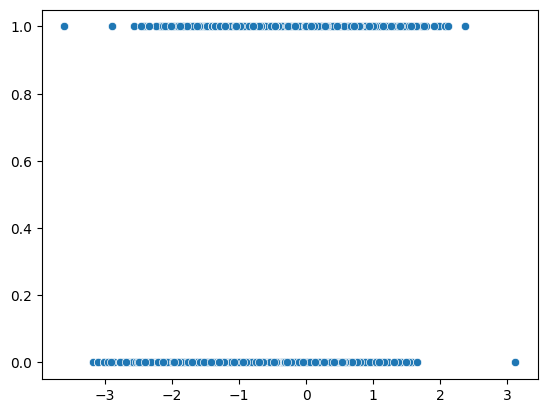

In [351]:
## Correlated covariates:
x_means = np.array([0,0,0])
X = rng.multivariate_normal(mean=x_means,cov=Sigma,size=N)
X = np.hstack([np.ones(N).reshape(-1, 1) ,X])
## Model:
alpha = -.6
beta = np.array([alpha,-.25,.5,.1])
sigma = .05

## Linear model:
y = X@beta + sigma*rng.normal(loc=0.0,scale=1.0,size=N) # LM

## Logistic model:
y_star = X@beta # Latent index
p_0 = 1/(1+np.exp(-y_star)) # Actual probabilities
p_1 = 1-p_0
d = ( p_0 > rng.uniform(low=0,high=1,size=N) ).astype(int) # Discrete outcomes

sns.scatterplot(y=d,x=y_star)

df_ols = pd.DataFrame({'y':y,
                       'x0':X[:,0],
                       'x1':X[:,1],
                        'x2':X[:,2],
                         'x3':X[:,3] })

df_lgt = pd.DataFrame({'d':d,
                      'x0':X[:,0],
                       'x1':X[:,1],
                        'x2':X[:,2],
                         'x3':X[:,3] })


[-0.61337916  0.32521234  0.13014337]


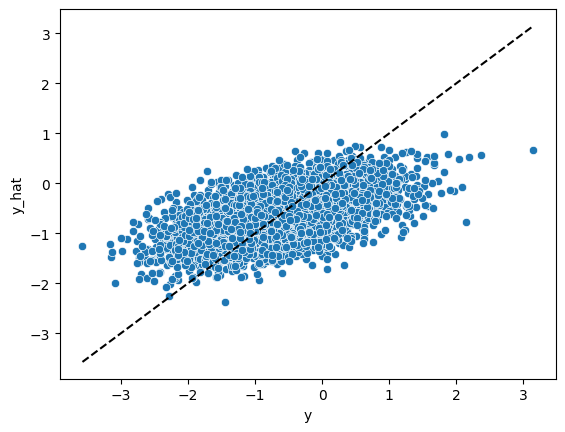

[-0.60063591 -0.25201222  0.5013277   0.09952401]


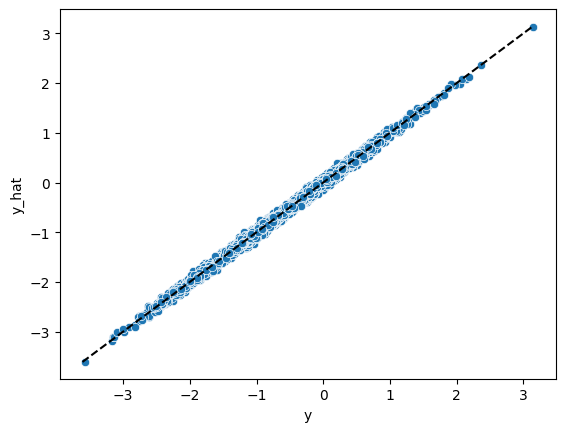

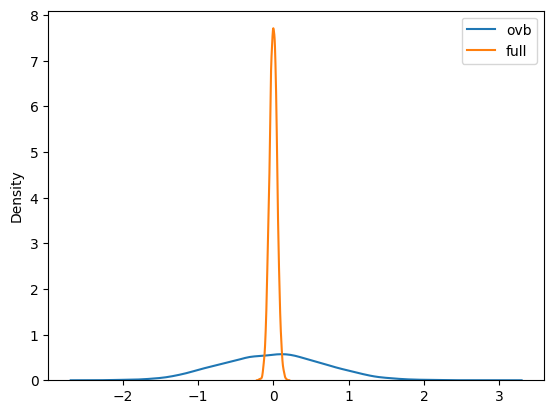

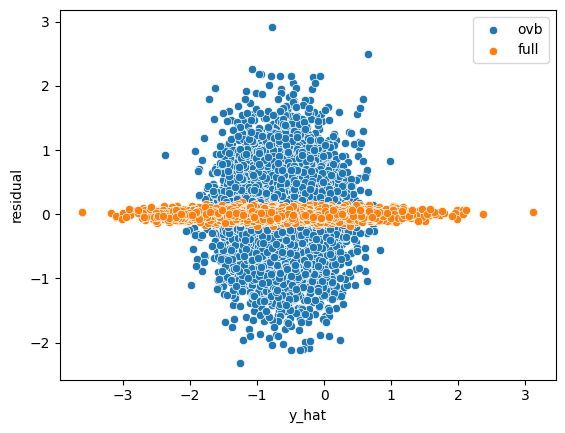

In [352]:
## OLS version of calibration plot
use = [0,1,3]

z = X[:,use]
beta_hat = np.linalg.solve( z.T@z, z.T@y)
print(beta_hat)

y_hat = z@beta_hat
y_hat_ovb = y_hat
r_ovb = y-y_hat
inf = min([min(y_hat), min(y)])
sup = max([max(y_hat),max(y)])

fig = sns.scatterplot(y=y_hat,x=y)
plt.plot((inf,sup),(inf,sup),'k--')
fig.set_xlabel('y')
fig.set_ylabel('y_hat')
plt.show()

use = [0,1,2,3]
z = X[:,use]
beta_hat = np.linalg.solve( z.T@z, z.T@y)
print(beta_hat)

y_hat = z@beta_hat
y_hat_full = y_hat
r_full = y-y_hat
inf = min([min(y_hat), min(y)])
sup = max([max(y_hat),max(y)])

fig = sns.scatterplot(y=y_hat,x=y)
plt.plot((inf,sup),(inf,sup),'k--')
fig.set_xlabel('y')
fig.set_ylabel('y_hat')
plt.show()

fig = sns.kdeplot(x=r_ovb,label='ovb')
sns.kdeplot(x=r_full,label='full')
plt.legend(loc='upper right')
plt.show()

fig = sns.scatterplot(x=y_hat_ovb,y=r_ovb,label='ovb')
sns.scatterplot(x=y_hat_full,y=r_full,label='full')
fig.set_xlabel('y_hat')
fig.set_ylabel('residual')
plt.legend(loc='upper right')
plt.show()



In [353]:
## Logistic regression functions
def F(z):
    r = 1/(1+np.exp(-z))
    return r

def logistic_reg(X,d,max_itr=1000):
    ## Iteration params
    err = 10
    eta = .01
    beta = np.zeros(X.shape[1])
    itr = 0
    eps = 1e-5
    ## Gradient descent
    while err > eps and itr < max_itr :
        latent = X @ beta
        F_0 = F(latent)
        F_1 = 1 - F_0
        gr = X.T @ ( F_1 - d  )/len(d)
        if itr>0: # Subsequent step size
            num = np.abs( np.inner(beta - beta_m1, gr - gr_m1) )
            den = np.sum( (gr-gr_m1)**2 )
            eta = num/den
        beta_p1 = beta + eta*gr
        err = np.sqrt(np.sum(gr**2))
        itr = itr+1
        beta_m1 = np.copy(beta)
        beta = np.copy(beta_p1)
        gr_m1 = np.copy(gr)
    residual = latent + (F_1 -d)/( F_0*F_1)
    print(f"Final error for iteration {itr} is {err}")
    return beta

[-0.6  -0.25  0.5   0.1 ]
Final error for iteration 17 is 6.832978577039653e-07
[ 0.64302845  0.2060692  -0.50653074 -0.11478593]
Final error for iteration 8 is 3.201139928191365e-06
[ 0.59489818 -0.32573286]


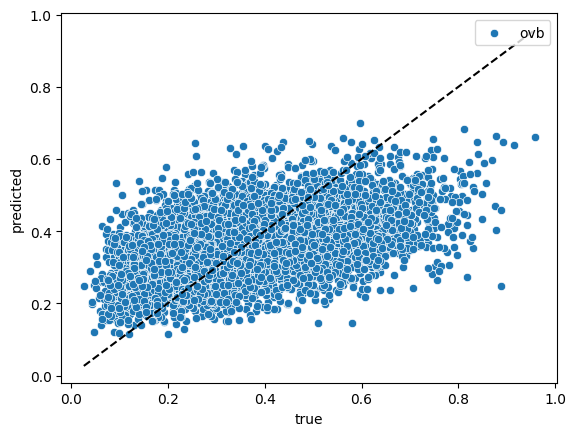

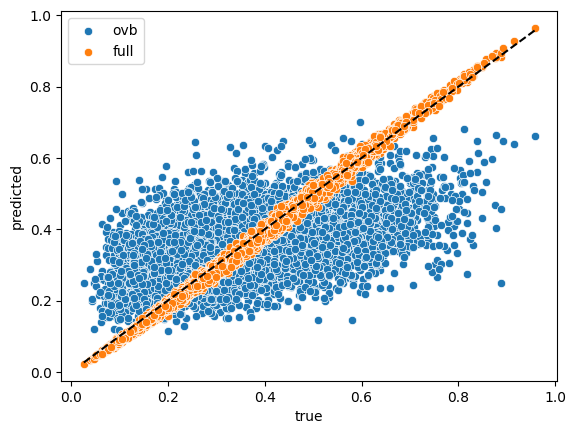

In [354]:
## Logistic version of calibration

print(beta)
beta_full = logistic_reg(X,d)
print(beta_full)
L_full = X @ beta_full
p_full = 1-F(L_full)
r_full = L_full + (p_full-d)/( p_full*(1-p_full) )

use = [0,1]
z = X[:,use]
beta_ovb = logistic_reg(z,d)
print(beta_ovb)
L_ovb = z @ beta_ovb
p_ovb = 1-F(L_ovb)
r_ovb = L_ovb + (p_ovb-d)/( p_ovb*(1-p_ovb) )

inf = min([min(p_ovb), min(p_0)])
sup = max([max(p_ovb),max(p_0)])
fig = sns.scatterplot(y=p_ovb,x=p_0,label='ovb')
plt.plot((inf,sup),(inf,sup),'k--')
fig.set_ylabel('predicted')
fig.set_xlabel('true')
plt.legend(loc='upper right')
plt.show()

inf = min([min(p_ovb), min(p_0)])
sup = max([max(p_ovb),max(p_0)])
fig = sns.scatterplot(y=p_ovb,x=p_0,label='ovb')
sns.scatterplot(y=p_full,x=p_0,label='full')
plt.plot((inf,sup),(inf,sup),'k--')
fig.set_ylabel('predicted')
fig.set_xlabel('true')
plt.legend(loc='upper left')
plt.show()



## Residual-based analysis for logistic regression

Instead of focusing on the local calibration plot, an alternative is to think about what residuals are for the logistic model and put bounds on them. 

If $L_i = X_i \beta$ and 
$$
F_i = \dfrac{1}{1+e^{-L_i}},
$$
then you can define a residual for logistic regression as:
$$
r_i = L_i + \dfrac{1-F(L_i)-d_i}{F_i(1-F_i)}
$$
or more generally for an arbitrary $F(z)$.  

This comes from iteratively reweighted least squares. If you take the Newton step
$$
\beta' = \beta - H(\beta)^{-1} g(\beta)
$$
and substitute and rearrange for a binary outcome model, you get
$$
\beta' =  \underbrace{( X' \Omega(\beta) X )^{-1} X'\Omega(\beta) }_{\text{Projection-like $(X'X)^{-1}X$ matrix}}\left[\underbrace{X\beta - \Omega(\beta)^{-1}\left( d_i \dfrac{f(-X\beta)}{1-F(-X\beta)} - (1-d_i) \dfrac{ f(-X\beta)}{F(-X\beta)}\right)}_{\text{"Residual"}} \right]
$$
where $\Omega(\beta)$ is a diagonal matrix with diagonal element
$$
\omega_{ii}(\beta) = d_i \dfrac{-f_i' (1-F_i)- f_i^2}{(1-F_i)^2} + (1-d_i) \dfrac{-f_i F_i + f_i^2}{F_i^2}.
$$
This gives another way of describing the deviation of $\hat{y}$ from $y$ for the binary outcomes case.


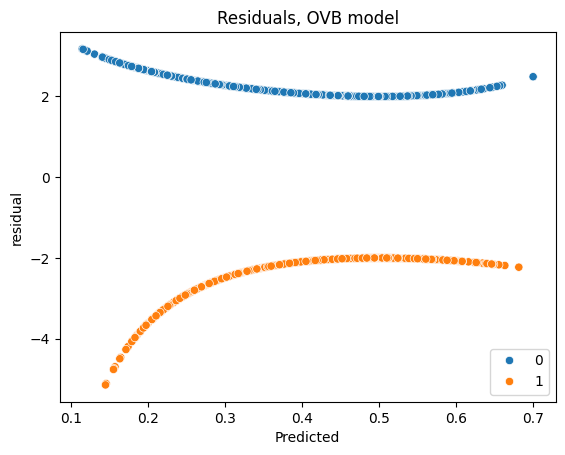

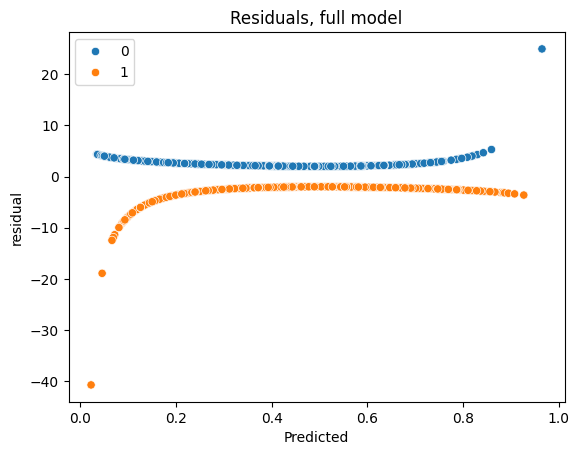

In [355]:
sns.scatterplot(x=p_ovb,y=r_ovb,hue=d).set(title='Residuals, OVB model',xlabel='Predicted',ylabel='residual')
plt.show()

sns.scatterplot(x=p_full,y=r_full,hue=d).set(title='Residuals, full model',xlabel='Predicted',ylabel='residual')
plt.show()

I think this is where you could impose a constraint on the initial maximization: These pseudo-residuals aren't too large:
$$
\forall i: \quad \left( L_i + \dfrac{1-F(L_i)-d_i}{F_i(1-F_i)} \right)^2 \le \tau
$$
 Such a constraint would collect the binding terms as $\tau$ decreases, and require the minimization of the binary cross entropy to adjust to reduce the individualized losses at the extremes. This gives you a calibration approach in the optimization framework, so it's a bit clearer what the "statistical intervention" is: I want to impose a uniform bound on my deviations in this space.

It's somewhat interesting or puzzling that the full model seems to get better results on average but not in the tails compared to the OVB model? That suggests to me that this constraint approach isn't a good idea? If the full model has larger pseduo-residuals than the OVB model, imposing constraints on it would just make its performance worse?

Maybe look directly at squared error:

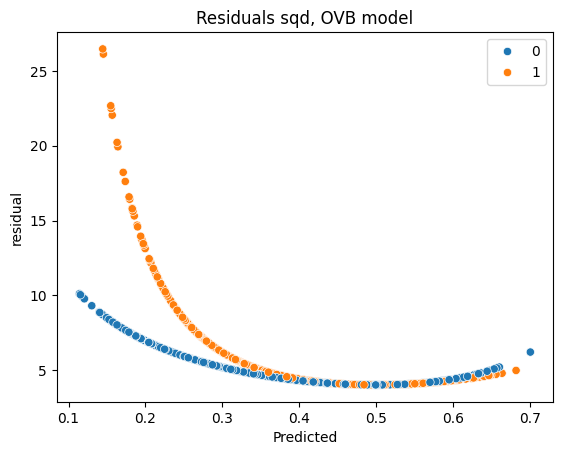

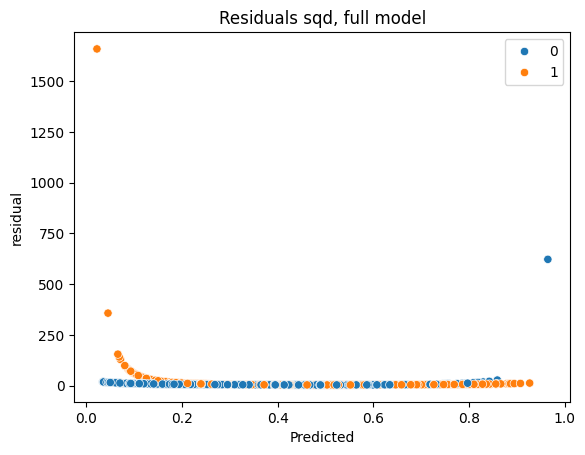

In [356]:
r_ovb_sq = np.pow(r_ovb,2)
sns.scatterplot(x=p_ovb,y=r_ovb_sq,hue=d).set(title='Residuals sqd, OVB model',xlabel='Predicted',ylabel='residual')
plt.show()

r_full_sq = np.pow(r_full,2)
sns.scatterplot(x=p_full,y=r_full_sq,hue=d).set(title='Residuals sqd, full model',xlabel='Predicted',ylabel='residual')
plt.show()

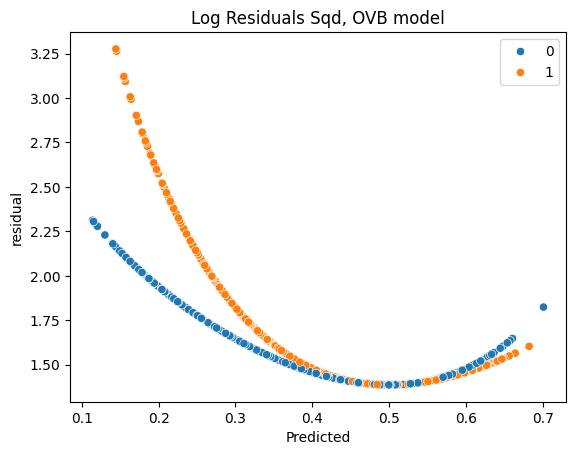

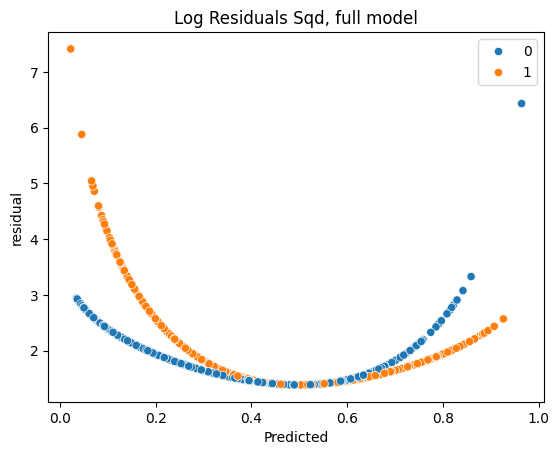

In [357]:
r_ovb_sq = np.log(np.pow(r_ovb,2))
sns.scatterplot(x=p_ovb,y=r_ovb_sq,hue=d).set(title='Log Residuals Sqd, OVB model',xlabel='Predicted',ylabel='residual')
plt.show()

r_full_sq = np.log(np.pow(r_full,2))
sns.scatterplot(x=p_full,y=r_full_sq,hue=d).set(title='Log Residuals Sqd, full model',xlabel='Predicted',ylabel='residual')
plt.show()

Huh.

If you stick with the residual as $\hat{y}-y$, you can plot that as:

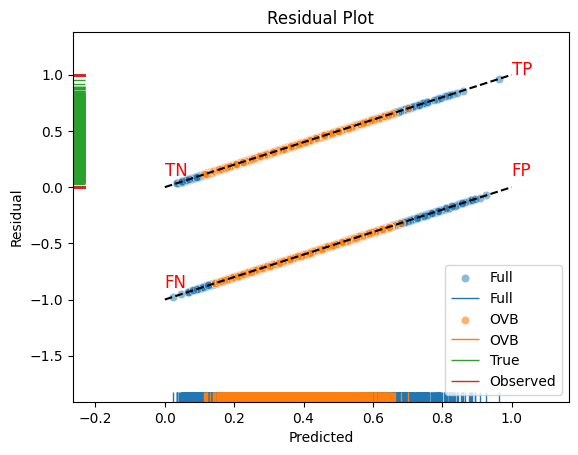

In [358]:
## Residual Plot
r_ovb = p_ovb - d
r_full = p_full - d
plt.plot((0,1),(0,1),'k--')
plt.plot((0,1),(-1,0),'k--')
plt.text(x=1, y=1, s="TP", fontsize=12, color='red')
plt.text(x=0.0, y=0.1, s="TN", fontsize=12, color='red')
plt.text(x=0, y=-.9, s="FN", fontsize=12, color='red')
plt.text(x=1, y=0.1, s="FP", fontsize=12, color='red')
plt.ylabel('Residual')
plt.xlabel('Predicted')
plt.title('Residual Plot')
sns.scatterplot(x=p_full,y=r_full,label='Full',alpha=.5)
sns.rugplot(x=p_full,label='Full')
sns.scatterplot(x=p_ovb,y=r_ovb,label='OVB',alpha=.6)
sns.rugplot(x=p_ovb,label='OVB')
sns.rugplot(y=p_0,label='True')
sns.rugplot(y=d,label='Observed')
plt.legend(loc='lower right')

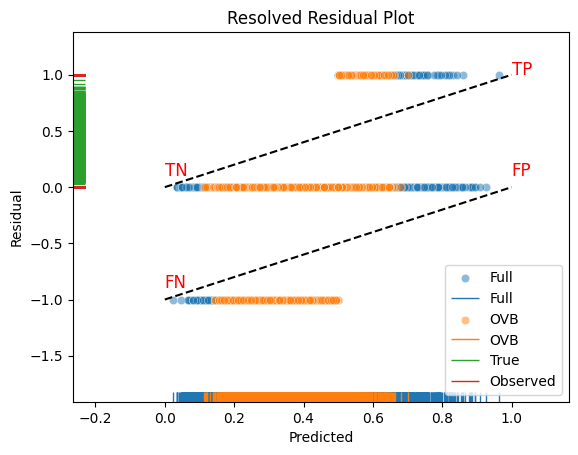

In [359]:
## Residual Plot
r_ovb = (p_ovb>.5).astype(int) - d
r_full = (p_full>.5).astype(int) - d
plt.plot((0,1),(0,1),'k--')
plt.plot((0,1),(-1,0),'k--')
plt.text(x=1, y=1, s="TP", fontsize=12, color='red')
plt.text(x=0.0, y=0.1, s="TN", fontsize=12, color='red')
plt.text(x=0, y=-.9, s="FN", fontsize=12, color='red')
plt.text(x=1, y=0.1, s="FP", fontsize=12, color='red')
plt.ylabel('Residual')
plt.xlabel('Predicted')
plt.title('Resolved Residual Plot')

sns.scatterplot(x=p_full,y=r_full,label='Full',alpha=.5)
sns.rugplot(x=p_full,label='Full')

sns.scatterplot(x=p_ovb,y=r_ovb,label='OVB',alpha=.5)
sns.rugplot(x=p_ovb,label='OVB')

sns.rugplot(y=p_0,label='True')
sns.rugplot(y=d,label='Observed')
plt.legend(loc='lower right')

In [360]:
print('OVB model: \n', pd.crosstab(d,(p_ovb>.5).astype(int)), '\n')
print('Full model: \n', pd.crosstab(d,(p_full>.5).astype(int)))

OVB model: 
 col_0     0    1
row_0           
0      3015  186
1      1593  206 

Full model: 
 col_0     0    1
row_0           
0      2766  435
1      1115  684


## Non-parametric estimation of bias function

Let's estimate the local proportion of $d=1$'s as
$$
\gamma(p) = \dfrac{\sum_{i=1}^N d_i \dfrac{1}{h}k( (p - \hat{p}_i)/h))}{\sum_{i=1}^N \dfrac{1}{h}k( (p - \hat{p}_i)/h))}
$$
with a Gaussian kernel; maybe a uniform kernel or something with finite support would be better.

In [361]:
## NP estimation of bias function 

#h_d = 1.06 * np.std(d) * np.pow(N,-.2)
h_ovb = 1.06 * np.std(p_ovb) * np.pow(N,-.2) * 1
h_full = 1.06 * np.std(p_full) * np.pow(N,-.2)

gamma = []
f_hat = []
for i in range(len(d)):
    p_hat = p_ovb[i]
    kernel = np.exp( -( (p_hat-p_ovb)/h_ovb )**2 ) / (h_ovb * np.sqrt(2*np.pi) )
    den = np.sum( kernel )/len(d)
    num = np.sum( d*kernel )/len(d)
    f_hat.append(den)
    gamma.append( num/den )

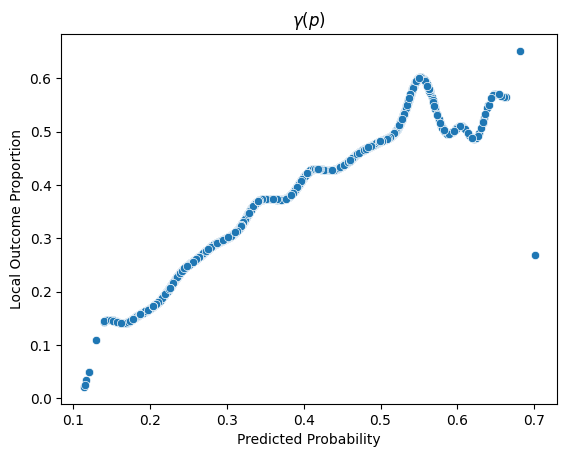

In [362]:
# sns.lineplot(x=p_ovb,y=f_hat)
# plt.show()
# sns.kdeplot(p_ovb)
# plt.show()

sns.scatterplot(x=p_ovb,y=gamma)
plt.ylabel('Local Outcome Proportion')
plt.xlabel('Predicted Probability')
plt.title('$\\gamma(p)$')
plt.show()

#sns.scatterplot(x=p_ovb,y=p_0)



In [363]:
df = pd.DataFrame({'d':d,'p':p_ovb,'p0':p_0})
df.head()

,d,p,p0
0,1,0.361249,0.671069
1,0,0.325337,0.261171
2,0,0.412510,0.100353
3,0,0.414430,0.442363
4,0,0.285323,0.517763


In [364]:
bks=np.linspace(start=0,stop=1,num=20)
df['group'] = pd.cut(df['p'], bins=bks)
df.head()

,d,p,p0,group
0,1,0.361249,0.671069,"(0.316, 0.368]"
1,0,0.325337,0.261171,"(0.316, 0.368]"
2,0,0.412510,0.100353,"(0.368, 0.421]"
3,0,0.414430,0.442363,"(0.368, 0.421]"
4,0,0.285323,0.517763,"(0.263, 0.316]"


In [365]:
df.loc[:,['d','group']].groupby('group').describe()

/tmp/ipykernel_21675/977163270.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.loc[:,['d','group']].groupby('group').describe()


d                                             
                  count      mean       std  min  25%  50%  75%  max
group                                                               
(0.0, 0.0526]       0.0       NaN       NaN  NaN  NaN  NaN  NaN  NaN
(0.0526, 0.105]     0.0       NaN       NaN  NaN  NaN  NaN  NaN  NaN
(0.105, 0.158]     35.0  0.142857  0.355036  0.0  0.0  0.0  0.0  1.0
(0.158, 0.211]    196.0  0.153061  0.360969  0.0  0.0  0.0  0.0  1.0
(0.211, 0.263]    539.0  0.230056  0.421259  0.0  0.0  0.0  0.0  1.0
(0.263, 0.316]    941.0  0.293305  0.455519  0.0  0.0  0.0  1.0  1.0
(0.316, 0.368]   1072.0  0.360075  0.480246  0.0  0.0  0.0  1.0  1.0
(0.368, 0.421]    956.0  0.404812  0.491112  0.0  0.0  0.0  1.0  1.0
(0.421, 0.474]    638.0  0.432602  0.495825  0.0  0.0  0.0  1.0  1.0
(0.474, 0.526]    396.0  0.477273  0.500115  0.0  0.0  0.0  1.0  1.0
(0.526, 0.579]    153.0  0.575163  0.495942  0.0  0.0  1.0  1.0  1.0
(0.579, 0.632]     52.0  0.500000  0.504878  0.0  0.0  0.5  1.0  1.0
(0.632, 0.684]     21.0  0.571429  0.507093  0.0  0.0  1.0  1.0  1.0
(0.684, 0.737]      1.0  0.000000       NaN  0.0  0.0  0.0  0.0  0.0
(0.737, 0.789]      0.0       NaN       NaN  NaN  NaN  NaN  NaN  NaN
(0.789, 0.842]      0.0       NaN       NaN  NaN  NaN  NaN  NaN  NaN
(0.842, 0.895]      0.0       NaN       NaN  NaN  NaN  NaN  NaN  NaN
(0.895, 0.947]      0.0       NaN       NaN  NaN  NaN  NaN  NaN  NaN
(0.947, 1.0]        0.0       NaN       NaN  NaN  NaN  NaN  NaN  NaN

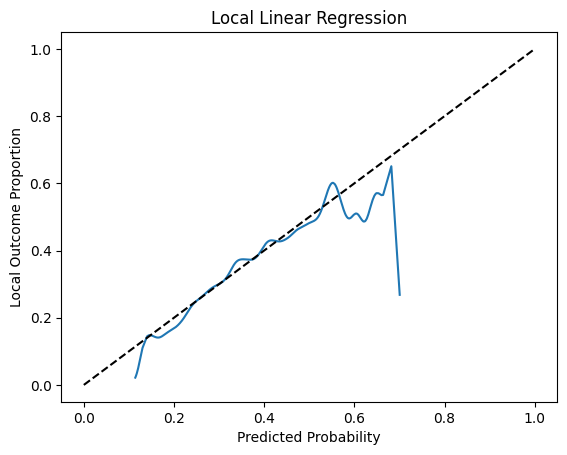

In [366]:
sns.lineplot(x=p_ovb,y=gamma)
plt.ylabel('Local Outcome Proportion')
plt.xlabel('Predicted Probability')
plt.title('Local Linear Regression')
inf = min([min(p_ovb), min(gamma)])
sup = max([max(p_ovb),max(gamma)])
plt.plot((0,1),(0,1),'k--')
plt.show()

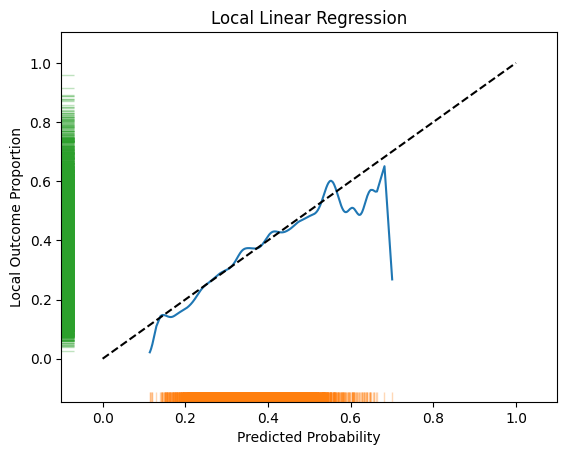

In [367]:
sns.lineplot(x=p_ovb,y=gamma)
plt.ylabel('Local Outcome Proportion')
plt.xlabel('Predicted Probability')
plt.title('Local Linear Regression')
inf = min([min(p_0), min(p_0)])
sup = max([max(p_0),max(p_0)])
sns.rugplot(x=p_ovb,alpha=.3)
sns.rugplot(y=p_0,alpha=.3)
plt.plot((0,1),(0,1),'k--')
plt.show()

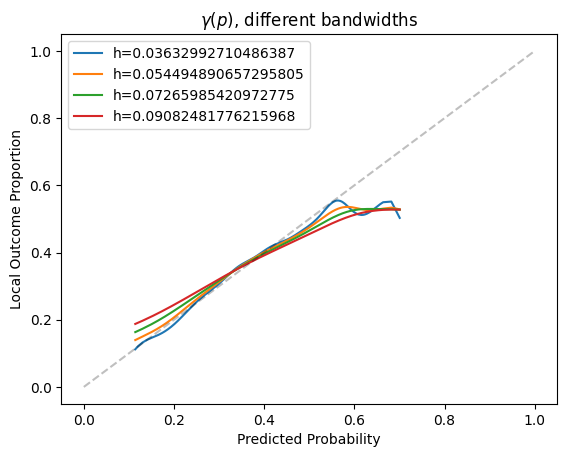

In [368]:
## NP estimation of bias function 

#h_d = 1.06 * np.std(d) * np.pow(N,-.2)
h_ovb = 1.06 * np.std(p_ovb) * np.pow(N,-.2) * 1
h_full = 1.06 * np.std(p_full) * np.pow(N,-.2)

h_grid = h_ovb * np.array([ 2, 3, 4, 5 ])

for h in h_grid:
    gamma = []
    f_hat = []
    for i in range(len(d)):
        p_hat = p_ovb[i]
        kernel = np.exp( -( (p_hat-p_ovb)/h )**2 ) / (h * np.sqrt(2*np.pi) )
        den = np.sum( kernel )/len(d)
        num = np.sum( d*kernel )/len(d)
        f_hat.append(den)
        gamma.append( num/den )
    sns.lineplot(x=p_ovb,y=gamma, label = 'h='+str(h))


# sns.lineplot(x=p_ovb,y=gamma)
plt.ylabel('Local Outcome Proportion')
plt.xlabel('Predicted Probability')
plt.title('$\\gamma(p)$, different bandwidths')
inf = min([min(p_0), min(p_0)])
sup = max([max(p_0),max(p_0)])
# sns.rugplot(x=p_ovb,alpha=.3)
# sns.rugplot(y=p_0,alpha=.3)
plt.plot((0,1),(0,1),'k--',alpha=.25)
plt.show()

Maybe incorporating confidence intervals is a way to do "robust calibration": If the uncertainty is high, use a conservative calibration correction to reflect the uncertainty.

For a large sample size, it seems like even with OVB, the model is converging to calibration, even if it's not converging to the truth. This surprises me, I guess: Biased models can be well-calibrated. Maybe it's not surprising: The optimization targeted binary cross entropy, and calibration is more of a question about performance conditional on $X$. I thought the OVB would introduce an inherent asymmetry as $X$ varied, but when you average over $X$, that asymmetry apparently vanishes? Huh.

Unobserved discrete heterogeneity might be a better way to bump that calibration curve off the diagonal. Then low values correspond to one group and high values to another, and smooth covariates won't have the discriminatory power alone to identify the mixture.

Ideally for me, there'd be a story/approach like:

1. Calibration typically fails because of phenomenon A
2. When this occurs, there's a probabilistic/statistical connection between the calibration curve and the phenomenon
3. If you adjust the values of your predictions ex post, you are removing the average bias relative to A on average in your predictions

but that's just me.